## Product Clustering

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_inventory=pd.read_csv('Inventory.csv', sep=',')
data_sales=pd.read_csv('Sales.csv', sep=',')
data_minprices=pd.read_csv('MinPrices.csv', sep=',')

## Data cleaning

- Checking the shape of the dataset and to see there is any negative or zero number for price.

In [3]:
print("Data inventory shape is :", data_inventory.shape)
data_inventory.sample(2)

Data inventory shape is : (374871, 4)


,pharm,minsan,price,quan
217148,F18,M45559,1.50,1
32436,F10,M6139,4.92,2


In [4]:
data_inventory[data_inventory['price']<=0]

,pharm,minsan,price,quan
1,F1,M2,-23.00,1
57,F1,M58,0.00,1
288968,F23,M34921,-16.54,1


- Dropping the rows with zero or negative prices in data inventory.

In [5]:
data_inventory.drop(data_inventory.index[data_inventory['price'] <= 0], inplace = True)

In [6]:
data_inventory.shape

(374868, 4)

- Checking null values in each column

In [7]:
data_inventory.isnull().sum()

pharm     0
minsan    0
price     0
quan      0
dtype: int64

- Dropping rows with duplicates

In [8]:
data_inventory=data_inventory.drop_duplicates(['pharm', 'minsan'], keep='last')

In [9]:
print("Final shape for data inventory is :", data_inventory.shape)

Final shape for data inventory is : (374864, 4)


In [10]:
print("Data sales shape is :", data_sales.shape)
data_sales.sample(2)

Data sales shape is : (3923, 4)


,minsan,qty,revenue,transactions
2116,M4181,1.0,17.32,1
140,M131,1.0,15.87,1


In [11]:
data_sales.isnull().sum()

minsan          0
qty             2
revenue         2
transactions    0
dtype: int64

- Dropping rows with null values.

In [12]:
data_sales=data_sales.dropna(subset=['qty', 'revenue'])

In [13]:
data_sales.shape

(3919, 4)

- Since a product can be sold on many channels, sum of revenue, sum of quantity and sum of transaction are calculated.

In [14]:
data_sales=data_sales.groupby('minsan').agg({'revenue': 'sum', 'qty': 'sum', 'transactions': 'sum'}).reset_index()

In [15]:
data_sales.shape

(2915, 4)

In [16]:
print("Data minPrice shape is :", data_minprices.shape)
data_minprices.sample(2)

Data minPrice shape is : (81318, 2)


,minsan,minPrice
19092,M29381,4.06
15189,M25773,19.77


- There is more than one min price in minprice dataset for 5 minsan. In this regard, I consider the minimum price and drop the greater one.

In [17]:
check=data_minprices.groupby('minsan')['minPrice'].nunique().reset_index()

In [18]:
check.minPrice.value_counts()

1    81307
2        5
Name: minPrice, dtype: int64

In [19]:
data_minprices=data_minprices.groupby('minsan')['minPrice'].min().reset_index()

In [20]:
data_minprices.shape

(81312, 2)

In [21]:
(data_minprices[data_minprices['minPrice']<=0]).shape

(29, 2)

- Droping the rows with zero and negative price amount.

In [22]:
data_minprices.drop(data_minprices.index[data_minprices['minPrice'] <= 0], inplace = True)

In [23]:
data_minprices.isnull().sum()

minsan      0
minPrice    0
dtype: int64

In [24]:
print("Sale shape: ",data_sales.shape)
print("Inventory shape: ",data_inventory.shape)
print("Min price shape: ",data_minprices.shape)

Sale shape:  (2915, 4)
Inventory shape:  (374864, 4)
Min price shape:  (81283, 2)


## Joining tables

- In this section the average amount of revenue for each product and the difference change of average price from its minimum price will be calculated.

In [25]:
R=data_sales.groupby('minsan')['revenue'].mean().reset_index(name='Ave.Revenue')

In [26]:
p=pd.merge(data_inventory, data_minprices, on='minsan', how='left')

In [27]:
print(p.shape)
p.sample(1)

(374864, 5)


,pharm,minsan,price,quan,minPrice
308539,F24,M32709,19.8,11,17.03


In [28]:
p.isnull().sum()

pharm           0
minsan          0
price           0
quan            0
minPrice    12493
dtype: int64

In [29]:
p=p.dropna(subset=['minPrice'])

- Average price of each product

In [30]:
p_Avg=p.groupby('minsan')['price'].mean().reset_index(name='Avg_Price')

In [31]:
aa=pd.merge(p_Avg, p, on='minsan', how='left')

- difference change of average price from its minimum price for each product

In [32]:
aa['Price_Difference_change']=(aa['Avg_Price']-aa['minPrice'])/aa['minPrice']

In [33]:
f=pd.merge(aa, R, on='minsan', how='inner')

In [34]:
f.isnull().sum()

minsan                     0
Avg_Price                  0
pharm                      0
price                      0
quan                       0
minPrice                   0
Price_Difference_change    0
Ave.Revenue                0
dtype: int64

In [35]:
f=f.drop_duplicates(['minsan', 'Avg_Price', 'minPrice', 'Price_Difference_change', 'Ave.Revenue'], keep='last')

In [36]:
cols=f[['Price_Difference_change', 'Ave.Revenue']]

## Clustering

- K-means clustering is implemented

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

In [38]:
# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(cols) 

In [39]:
# Normalizing the Data 
normalized_df = normalize(scaled_df) 

In [40]:
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
normalized_df.columns = ['P1', 'P2'] 

- In this task the number of clusters have been determined, but we can also see the optimal number of clusters

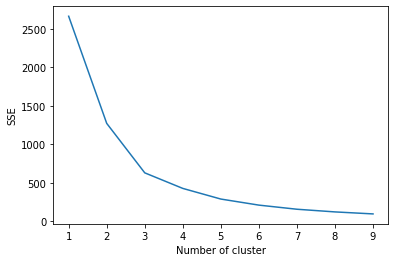

In [41]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(normalized_df)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

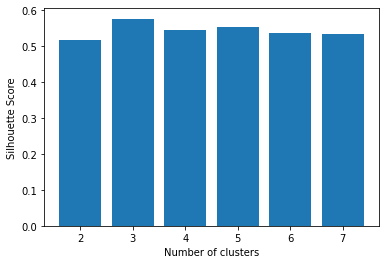

In [42]:
silhouette_scores = [] 

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(normalized_df, KMeans(n_clusters = n_cluster).fit_predict(normalized_df))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6,7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

In [43]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(normalized_df)

KMeans(n_clusters=5)

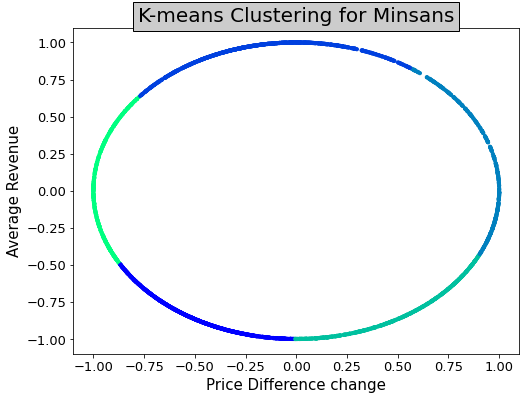

In [44]:
# Visualizing the clustering 
plt.figure(figsize=(8,6))

plt.title("K-means Clustering for Minsans", bbox={'facecolor':'0.8', 'pad':5}, fontsize=20)
plt.scatter(normalized_df['P1'], normalized_df['P2'], s=10, 
           c = KMeans(n_clusters = 5).fit_predict(normalized_df), cmap =plt.cm.winter)
plt.xlabel('Price Difference change', fontsize=15);
plt.xticks(fontsize= 13)
plt.ylabel('Average Revenue', fontsize=15);
plt.yticks(fontsize= 13)
plt.show() 

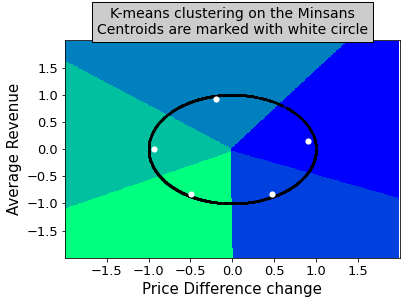

In [45]:
h = .01     

x_min, x_max = normalized_df['P1'].min() - 1, normalized_df['P1'].max() + 1
y_min, y_max = normalized_df['P2'].min() - 1, normalized_df['P2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.array(list(zip(xx.ravel(), yy.ravel()))))

Z = Z.reshape(xx.shape)
plt.figure(1)

plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.winter,
           aspect='auto', origin='lower')

plt.plot(normalized_df['P1'], normalized_df['P2'], 'k.', markersize=2)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='o', s=10, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the Minsans\n'
          'Centroids are marked with white circle', bbox={'facecolor':'0.8', 'pad':5}, fontsize=14)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Price Difference change', fontsize=15);
plt.xticks(fontsize= 13)
plt.ylabel('Average Revenue', fontsize=15);
plt.yticks(fontsize= 13)
plt.show()

In this clustering after feature engineering two features have been considered. first the average revenue of each product and then the price difference change of each average product from its minimum price. When the revenue of the product is high it worth to push the adverstiment for that product. on the other hand when the average price of the product is more close to the minimum price, it means the price is already competitive and probably there is no need to put budget for advertisement. 

- The bright green cluster that has low revenue and low price difference change, we can stop advertisement on this cluster because the price is competitive and the revenue is low. 
- The dark green part which has medium revenue and low price difference, we can continue advertisement as we are doing now. 
- Bright blue part with medium price difference and high revenue worth to assign budget for more advertisement.
- The darker blue cluster needs to push advertisement, because the revenue and price difference is high. 
- Dark blue part keep advertisement as it is doing now because the price is high and the revenue is low.